In [1]:
from collections import Counter

import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE


### What is being done here
1. Create a dataset with both df_train & df_test only demographic columns (-weight and height as bmi which is a derived column is included)
2. Remove all null and invalid rows
3. Created age bins so that the distribution is not too imbalanced
4. Convert categorical columns to dummy columns 
5. Build classifiers with and w/o SMOTE using 
    - Decision Tree model
    - Build Gaussian Naive Bayes model

### Common functions

In [2]:
TEST_DS_SIZE = 0.2
DEMO1_COLS = ['encounter_id', 'age', 'gender', 'ethnicity', 'bmi'] #'weight', 'height',
DT_DEPTH = 4


In [3]:
AGE_LABELS = [ '(-0.1, 0]',
               '(0, 12.9]',
               '(12.9, 40.0]',
               '(40.0, 50.0]',
               '(50.0, 60.0]',
               '(60.0, 70.0]',
               '(70.0, 80.0]',
               '(80.0, 120.0]']
'''
17.9]',
               '(17.9, 30.0]',
               '(30.0,
17.9, 30,
'''
def AGE_BINS(df):
      return pd.cut(df['age'], [-0.1, 0, 12.9,  40, 50, 60, 70, 80, 120], labels=AGE_LABELS)

def _agedist(df, df_name):
    total_count = df.shape[0]
    nan_count = df[df['age'].isnull()].shape[0]
    nan_pc = nan_count/total_count

    ages = df['age'].unique()
    ages.sort()
    # Since age has 0.0 values, these should be ignored/replaced
    min_age = ages[1]
    print(f"Invalid age: {df[df['age']==0.0]['age'].count()} Min: {df['age'].min():0.2f} Max: {df['age'].max():0.2f}")

    # Group the ages based on the age-groups
    #bins = pd.cut(df['age'], AGE_BINS)
    df_age = df.groupby(AGE_BINS(df))['age'].agg(['count'])
    df_age = df_age.reset_index()

    # Append the null value counts
    df_age = df_age.append(pd.DataFrame([['null', nan_count]], columns = ['age', f'count']))

    # Add a percentage column
    df_age[f'{df_name}_%'] = 100 * df_age['count']/total_count
    df_age = df_age.rename(columns = {'count':f"{df_name}_count"})

    df_age.plot.bar(x='age', y='total_count')

    #print(df_age)
    print(f"Verification:   {df_name}_count: {df_age[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_age[f'{df_name}_%'].sum():0.1f}%")
    return df_age, nan_count, nan_pc

# underweight, normal, overweight, obese
BMI_LABELS = [ '[0.0 - 18.5] underweight',
               '[18.5 - 24.9] normal weight',
               '[25 -  30] over weight',
               '[70  <] obese']

def BMI_BINS(df):
      return pd.cut(df['bmi'], [0, 18.5, 24.9, 30, 70], labels=BMI_LABELS)

def _bmidist(df, df_name):
    total_count = df.shape[0]
    nan_count = df[df['bmi'].isnull()].shape[0]
    nan_pc = nan_count/total_count
    print(f"Min: {df['bmi'].min():0.2f} Max: {df['bmi'].max():0.2f}")

    # Group the values based on the bmi-categories
    #bins = pd.cut(df['bmi'], BMI_BINS, labels=BMI_LABELS)
    df_bmi = df.groupby(BMI_BINS(df))['bmi'].agg(['count'])
    df_bmi = df_bmi.reset_index()

    # Append the null value counts
    df_bmi = df_bmi.append(pd.DataFrame([['null', nan_count]], columns = ['bmi', f'count']))

    # Add a percentage column
    df_bmi[f"{df_name}_%"] = 100 * df_bmi['count']/total_count
    df_bmi = df_bmi.rename(columns = {'count':f"{df_name}_count"})

    print(df_bmi)
    print(f"Verification:   {df_name}_count: {df_bmi[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_bmi[f'{df_name}_%'].sum():0.1f}%")
    return df_bmi, nan_count, nan_pc

def oversample(X, y):
      # transform the dataset
      oversample = SMOTE()
      X, y = oversample.fit_resample(X, y)
      # summarize distribution
      counter = Counter(y)
      for k,v in counter.items():
            per = v / len(y) * 100
            print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
      return X,y,counter

def predictWithDecisionTree(X_train, y_train, X_test, y_test):
    dtree_model = DecisionTreeClassifier(max_depth = DT_DEPTH).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    # accuracy on X_test 
    accuracy = dtree_model.score(X_test, y_test) 
    print(accuracy) 
    plot_confusion_matrix(dtree_model, X_test, y_test) 
    return accuracy

def predictWithGaussianNaiveBayes(X_train, y_train, X_test, y_test):
      gnb = GaussianNB().fit(X_train, y_train) 
      gnb_predictions = gnb.predict(X_test) 

      # accuracy on X_test 
      accuracy = gnb.score(X_test, y_test) 
      print(accuracy) 
      plot_confusion_matrix(gnb, X_test, y_test) 
      return accuracy

#### Combine the train and the unlabelled datasets (only demographic columns)
- Remove rows with invalid ages (30) 
- Remove null rows

In [4]:
df_train = pd.read_csv("data/TrainingWiDS2021.csv", usecols = DEMO1_COLS)
df_train.shape[0]

130157

In [5]:
df_unlabeled = pd.read_csv("data/UnlabeledWiDS2021.csv", usecols = DEMO1_COLS)
df_unlabeled.shape[0]

10234

In [6]:
df_total = pd.concat([df_train, df_unlabeled])
df_total.shape[0]

140391

Invalid age: 30 Min: 0.00 Max: 96.00
Verification:   total_count: 140391 total_%: 100.0%


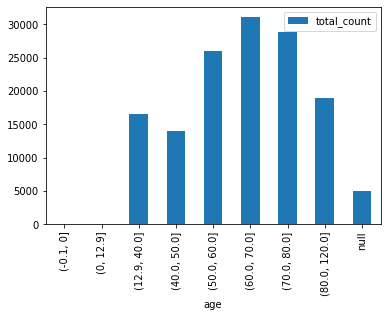

In [7]:
df_age, _, _  = _agedist(df_total, 'total')

In [8]:
df_age

,age,total_count,total_%
0,"(-0.1, 0]",30,0.021369
1,"(0, 12.9]",0,0.000000
2,"(12.9, 40.0]",16508,11.758589
3,"(40.0, 50.0]",14017,9.984258
4,"(50.0, 60.0]",25925,18.466283
5,"(60.0, 70.0]",31063,22.126062
6,"(70.0, 80.0]",28901,20.586077
7,"(80.0, 120.0]",18959,13.504427
0,null,4988,3.552934


In [9]:
_bmidist(df_total, 'total')

Min: 14.84 Max: 69.94
                           bmi  total_count    total_%
0     [0.0 - 18.5] underweight         5711   4.067925
1  [18.5 - 24.9] normal weight        38666  27.541652
2       [25 -  30] over weight        40873  29.113690
3                [70  <] obese        49636  35.355543
0                         null         5505   3.921192
Verification:   total_count: 140391 total_%: 100.0%


(                           bmi  total_count    total_%
 0     [0.0 - 18.5] underweight         5711   4.067925
 1  [18.5 - 24.9] normal weight        38666  27.541652
 2       [25 -  30] over weight        40873  29.113690
 3                [70  <] obese        49636  35.355543
 0                         null         5505   3.921192,
 5505,
 0.039211915293715406)

In [10]:
df_total = df_total[(df_total['age']!=0.0) & (df_total['age'].notnull())]
df_total.shape[0]

135373

Invalid age: 0 Min: 16.00 Max: 96.00
Verification:   total_count: 135373 total_%: 100.0%


(             age  total_count    total_%
 0      (-0.1, 0]            0   0.000000
 1      (0, 12.9]            0   0.000000
 2   (12.9, 40.0]        16508  12.194455
 3   (40.0, 50.0]        14017  10.354354
 4   (50.0, 60.0]        25925  19.150791
 5   (60.0, 70.0]        31063  22.946230
 6   (70.0, 80.0]        28901  21.349161
 7  (80.0, 120.0]        18959  14.005008
 0           null            0   0.000000,
 0,
 0.0)

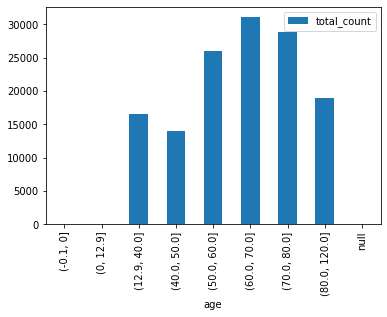

In [11]:
_agedist(df_total, 'total')

In [12]:
df_total.groupby(['age', 'gender', 'ethnicity']).agg(['count'])

encounter_id   bmi
                                    count count
age  gender ethnicity                          
16.0 F      African American            7     7
            Asian                       1     1
            Caucasian                  37    35
            Native American             1     1
            Other/Unknown               1     1
...                                   ...   ...
96.0 F      Caucasian                  15    15
     M      African American            1     1
            Caucasian                   8     7
            Hispanic                    1     1
            Other/Unknown               1     1

[927 rows x 2 columns]

In [13]:
df_total[df_total.isnull().any(axis=1)].count()

encounter_id    6786
age             6786
bmi             1493
ethnicity       5082
gender          6759
dtype: int64

In [14]:
df_total = df_total.dropna()

In [15]:
df_total.shape[0]

128587

Invalid age: 0 Min: 16.00 Max: 96.00
Verification:   total_count: 128587 total_%: 100.0%


(             age  total_count    total_%
 0      (-0.1, 0]            0   0.000000
 1      (0, 12.9]            0   0.000000
 2   (12.9, 40.0]        15569  12.107756
 3   (40.0, 50.0]        13282  10.329193
 4   (50.0, 60.0]        24667  19.183121
 5   (60.0, 70.0]        29596  23.016324
 6   (70.0, 80.0]        27485  21.374634
 7  (80.0, 120.0]        17988  13.988972
 0           null            0   0.000000,
 0,
 0.0)

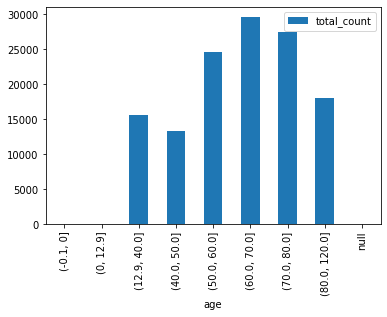

In [16]:
_agedist(df_total, 'total')

#### Add age and bmi categories

In [17]:
df_total.insert(5,'bmi_cat', BMI_BINS(df_total))

In [18]:
df_total.insert(6,'age_group',AGE_BINS(df_total))

In [19]:
df_total.columns

Index(['encounter_id', 'age', 'bmi', 'ethnicity', 'gender', 'bmi_cat',
       'age_group'],
      dtype='object')

In [20]:
df_total

,encounter_id,age,bmi,ethnicity,gender,bmi_cat,age_group
0,214826,68.0,22.732803,Caucasian,M,[18.5 - 24.9] normal weight,"(60.0, 70.0]"
1,246060,77.0,27.421875,Caucasian,F,[25 - 30] over weight,"(70.0, 80.0]"
2,276985,25.0,31.952749,Caucasian,F,[70 <] obese,"(12.9, 40.0]"
3,262220,81.0,22.635548,Caucasian,F,[18.5 - 24.9] normal weight,"(80.0, 120.0]"
5,182697,67.0,27.555611,Caucasian,M,[25 - 30] over weight,"(60.0, 70.0]"
...,...,...,...,...,...,...,...
10229,143750,36.0,37.500000,Caucasian,F,[70 <] obese,"(12.9, 40.0]"
10230,143813,61.0,32.100000,Caucasian,F,[70 <] obese,"(60.0, 70.0]"
10231,137126,74.0,22.700000,Caucasian,F,[18.5 - 24.9] normal weight,"(70.0, 80.0]"
10232,135652,90.0,19.900000,Caucasian,F,[18.5 - 24.9] normal weight,"(80.0, 120.0]"


In [21]:
df_total['age_group'].value_counts()

(60.0, 70.0]     29596
(70.0, 80.0]     27485
(50.0, 60.0]     24667
(80.0, 120.0]    17988
(12.9, 40.0]     15569
(40.0, 50.0]     13282
(-0.1, 0]            0
(0, 12.9]            0
Name: age_group, dtype: int64

In [22]:
df_total

,encounter_id,age,bmi,ethnicity,gender,bmi_cat,age_group
0,214826,68.0,22.732803,Caucasian,M,[18.5 - 24.9] normal weight,"(60.0, 70.0]"
1,246060,77.0,27.421875,Caucasian,F,[25 - 30] over weight,"(70.0, 80.0]"
2,276985,25.0,31.952749,Caucasian,F,[70 <] obese,"(12.9, 40.0]"
3,262220,81.0,22.635548,Caucasian,F,[18.5 - 24.9] normal weight,"(80.0, 120.0]"
5,182697,67.0,27.555611,Caucasian,M,[25 - 30] over weight,"(60.0, 70.0]"
...,...,...,...,...,...,...,...
10229,143750,36.0,37.500000,Caucasian,F,[70 <] obese,"(12.9, 40.0]"
10230,143813,61.0,32.100000,Caucasian,F,[70 <] obese,"(60.0, 70.0]"
10231,137126,74.0,22.700000,Caucasian,F,[18.5 - 24.9] normal weight,"(70.0, 80.0]"
10232,135652,90.0,19.900000,Caucasian,F,[18.5 - 24.9] normal weight,"(80.0, 120.0]"


#### Convert categorical columns to dummies

In [23]:
df_new = df_total[['gender', 'ethnicity', 'bmi_cat']] #, 'height', 'weight']]
df_new

,gender,ethnicity,bmi_cat
0,M,Caucasian,[18.5 - 24.9] normal weight
1,F,Caucasian,[25 - 30] over weight
2,F,Caucasian,[70 <] obese
3,F,Caucasian,[18.5 - 24.9] normal weight
5,M,Caucasian,[25 - 30] over weight
...,...,...,...
10229,F,Caucasian,[70 <] obese
10230,F,Caucasian,[70 <] obese
10231,F,Caucasian,[18.5 - 24.9] normal weight
10232,F,Caucasian,[18.5 - 24.9] normal weight


In [24]:
import pandas as pd
df_new = pd.get_dummies(df_new, prefix = ['gender', 'ethnicity', 'bmi_cat'])

In [25]:
df_new

,gender_F,gender_M,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,bmi_cat_[0.0 - 18.5] underweight,bmi_cat_[18.5 - 24.9] normal weight,bmi_cat_[25 - 30] over weight,bmi_cat_[70 <] obese
0,0,1,0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,1,0,0
5,0,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,1,0,0,0,1,0,0,0,0,0,0,1
10230,1,0,0,0,1,0,0,0,0,0,0,1
10231,1,0,0,0,1,0,0,0,0,1,0,0
10232,1,0,0,0,1,0,0,0,0,1,0,0


In [26]:
df_index = pd.concat([df_new, df_total['age_group']], join = 'outer', axis = 1) 

#### Convert age groups from categorical to numerical

In [27]:
def mapintfromgroup(age_group):
    print(age_group)
    
    if age_group == '(12.9, 40.0]':
        return 1
    elif age_group == '(40.0, 50.0]':
        return 2
    elif age_group == '(50.0, 60.0]':
        return 3
    elif age_group == '(60.0, 70.0]':
        return 4
    elif age_group == '(70.0, 80.0]':
        return 5
    elif age_group == '(80.0, 120.0]':
        return 6
    else:
        return 7
    '''
    if age_group == '(-0.1, 0]':
         return 1
    elif age_group == '(0, 12.9]':
        return 2
    elif age_group == '(12.9, 17.9]':
        return 3
    elif age_group == '(17.9, 30.0]':
        return 4
    elif age_group == '(30.0, 50.0]':
        return 5
    elif age_group == '(50.0, 70.0]':
        return 6
    elif age_group == '(70.0, 90.0]':
        return 7
    elif age_group == '(90.0, 120.0]':
        return 8
    else:
        return 9
    '''

In [28]:
df_index['age'] = df_index['age_group'].apply(lambda age_group: mapintfromgroup(age_group))

(-0.1, 0]
(0, 12.9]
(12.9, 40.0]
(40.0, 50.0]
(50.0, 60.0]
(60.0, 70.0]
(70.0, 80.0]
(80.0, 120.0]


In [29]:
df_index

,gender_F,gender_M,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,bmi_cat_[0.0 - 18.5] underweight,bmi_cat_[18.5 - 24.9] normal weight,bmi_cat_[25 - 30] over weight,bmi_cat_[70 <] obese,age_group,age
0,0,1,0,0,1,0,0,0,0,1,0,0,"(60.0, 70.0]",4
1,1,0,0,0,1,0,0,0,0,0,1,0,"(70.0, 80.0]",5
2,1,0,0,0,1,0,0,0,0,0,0,1,"(12.9, 40.0]",1
3,1,0,0,0,1,0,0,0,0,1,0,0,"(80.0, 120.0]",6
5,0,1,0,0,1,0,0,0,0,0,1,0,"(60.0, 70.0]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,1,0,0,0,1,0,0,0,0,0,0,1,"(12.9, 40.0]",1
10230,1,0,0,0,1,0,0,0,0,0,0,1,"(60.0, 70.0]",4
10231,1,0,0,0,1,0,0,0,0,1,0,0,"(70.0, 80.0]",5
10232,1,0,0,0,1,0,0,0,0,1,0,0,"(80.0, 120.0]",6


In [30]:
df_new = df_index.drop(columns=['age_group'])

In [31]:
df_new

,gender_F,gender_M,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,bmi_cat_[0.0 - 18.5] underweight,bmi_cat_[18.5 - 24.9] normal weight,bmi_cat_[25 - 30] over weight,bmi_cat_[70 <] obese,age
0,0,1,0,0,1,0,0,0,0,1,0,0,4
1,1,0,0,0,1,0,0,0,0,0,1,0,5
2,1,0,0,0,1,0,0,0,0,0,0,1,1
3,1,0,0,0,1,0,0,0,0,1,0,0,6
5,0,1,0,0,1,0,0,0,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,1,0,0,0,1,0,0,0,0,0,0,1,1
10230,1,0,0,0,1,0,0,0,0,0,0,1,4
10231,1,0,0,0,1,0,0,0,0,1,0,0,5
10232,1,0,0,0,1,0,0,0,0,1,0,0,6


In [32]:

# split into input and output elements
data = df_new.values


In [33]:
data

array([[0, 1, 0, ..., 0, 0, 4],
       [1, 0, 0, ..., 1, 0, 5],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 5],
       [1, 0, 0, ..., 0, 0, 6],
       [0, 1, 0, ..., 1, 0, 1]])

In [34]:
X, y = data[:, :-1], data[:, -1]

In [35]:
type(X); type(y)

numpy.ndarray

In [36]:
X

array([[0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [37]:
y

array([4, 5, 1, ..., 5, 6, 1])

Class=3, n=29596 (23.016%)
Class=4, n=27485 (21.375%)
Class=0, n=15569 (12.108%)
Class=5, n=17988 (13.989%)
Class=2, n=24667 (19.183%)
Class=1, n=13282 (10.329%)


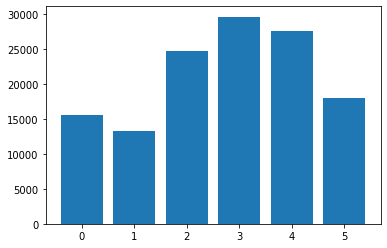

In [38]:
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## Without oversampling

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_DS_SIZE, random_state=0)
print(X_train.shape[0],X_test.shape[0])

102869 25718


0.2487751769188895


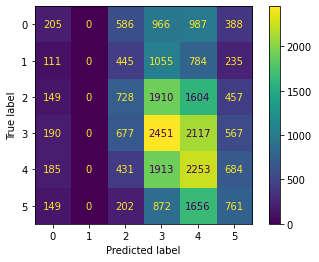

In [40]:
acc_WO_DT = predictWithDecisionTree(X_train, y_train, X_test, y_test)

0.23314410140757447


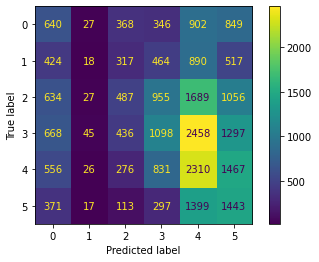

In [41]:
acc_NO_NB = predictWithGaussianNaiveBayes(X_train, y_train, X_test, y_test)

### Oversampling using SMOTE

Class=3, n=29596 (16.667%)
Class=4, n=29596 (16.667%)
Class=0, n=29596 (16.667%)
Class=5, n=29596 (16.667%)
Class=2, n=29596 (16.667%)
Class=1, n=29596 (16.667%)


<BarContainer object of 6 artists>

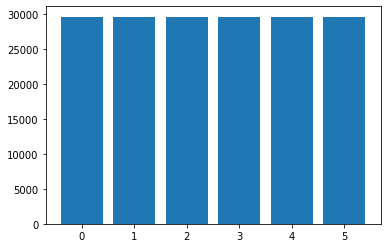

In [42]:
X, y, counter = oversample(X, y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_DS_SIZE, random_state=0)
print(X_train.shape[0],X_test.shape[0])

142060 35516


0.22097083004842888


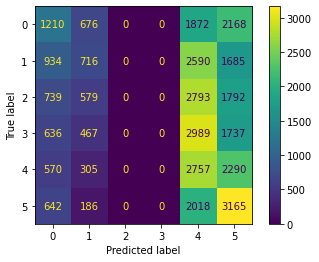

In [44]:
acc_NO_NB = predictWithGaussianNaiveBayes(X_train, y_train, X_test, y_test)